#F in the chat for Google Colab RAM and GPU

In [ ]:
%%shell

# tar -czvf RealBlurDataset.tar RealBlur-J_ECC_IMCORR_centroid_itensity_ref RealBlur_J_test_list.txt RealBlur_J_train_list.txt
cp /content/GOPRO_Dataset.zip "/content/drive/MyDrive/EE371Q/GOPRO_Dataset.zip"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(i + 1)

980


In [ ]:
%%shell
cp /content/reflect_train_epoch_150.pt "/content/drive/MyDrive/EE371Q/Reflect"
cp /content/g_loss_list_150.pt "/content/drive/MyDrive/EE371Q/Reflect"
cp /content/d_loss_list_150.pt "/content/drive/MyDrive/EE371Q/Reflect"

In [ ]:
%%shell
cp /content/replicate_train_epoch_40.pt "/content/drive/MyDrive/EE371Q/Replicate"
cp /content/g_loss_list_40.pt "/content/drive/MyDrive/EE371Q/Replicate"
cp /content/d_loss_list_40.pt "/content/drive/MyDrive/EE371Q/Replicate"

In [ ]:
%%shell
rm -r /content/*.pt

In [7]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

In [ ]:
epoch_num = 90
state = torch.load(f'/content/drive/MyDrive/EE371Q/Reflect/reflect_train_epoch_{epoch_num}.pt')
# epoch_num += 1

Unzipping Dataset

In [4]:
!tar -xvf "/content/drive/MyDrive/EE371Q/RealBlurDataset.tar"

Streaming output truncated to the last 5000 lines.
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene138/blur/blur_11.png
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene138/blur/blur_7.png
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene138/blur/blur_2.png
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene070/
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene070/gt/
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene070/gt/gt_11.png
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene070/gt/gt_4.png
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene070/gt/gt_20.png
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene070/gt/gt_9.png
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene070/gt/gt_15.png
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene070/gt/gt_16.png
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene070/gt/gt_14.png
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene070/gt/gt_1.png
RealBlur-J_ECC_IMCORR_centroid_itensity_ref/scene070/gt/gt_5.png
RealBlur-J_ECC_IMCORR_centroid_itensity_

In [ ]:
!unzip "/content/drive/MyDrive/EE371Q/GOPRO_Large.zip"

Loading training and test splits

In [5]:
class RealBlurDataset():
    def __init__(self, train_list, transforms=None, crop_size=(256, 256), rand_flip=0.5):
        self.train_list = train_list
        self.transforms = transforms
        self.crop_size = crop_size
        self.rand_flip = rand_flip
        random.seed()
    
    def len(self):
        return len(self.train_list)

    def get_item(self, idx):
        if idx >= self.len():
            return None
        
        img_name = train_list.iloc[idx].values[0].split(' ')
        image_sharp = Image.open(img_name[0])
        image_blur = Image.open(img_name[1])

        # Setting the points for cropped image
        # left = int(random.randint(0, int(image_sharp.size[0] - self.crop_size[0])))
        # top = int(random.randint(0, int(image_sharp.size[1] - self.crop_size[1])))

        # if random.random() > self.rand_flip:
        #     image_sharp = image_sharp.transpose(Image.FLIP_LEFT_RIGHT)
        #     image_blur = image_blur.transpose(Image.FLIP_LEFT_RIGHT)
        
        # Cropped image of above dimension
        # image_sharp = image_sharp.crop((left, top, left + self.crop_size[0], top + self.crop_size[1]))
        # image_blur = image_blur.crop((left, top, left + self.crop_size[0], top + self.crop_size[1]))

        if self.transforms is not None:
            image_sharp = self.transforms(image_sharp)
            image_blur = self.transforms(image_blur)

        return image_sharp, image_blur
    
    def get_batch(self, batch_idx, batch_size=1):
        batch = []
        for i in range(batch_size):
            item = self.get_item(batch_idx * batch_size + i)

            if item is not None:
                batch.append(item)

        return batch

    def get_transforms(self):
        return self.transforms

PatchGAN discriminator
https://paperswithcode.com/method/patchgan

In [ ]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=256):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, d, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d, d * 2, 4, 2, 1),
            nn.BatchNorm2d(d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d * 2, d * 4, 4, 2, 1),
            nn.BatchNorm2d(d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d * 4, d * 8, 4, 2, 1),
            nn.BatchNorm2d(d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d * 8, 1, 4, 1, 0),
            nn.Flatten(),
            nn.Linear(169, 1),
            nn.Sigmoid()
        )

    # forward method
    def forward(self, input):
        output = self.model(input)

        return output

In [ ]:
def create_resnet_block():
  resnet_block = nn.Sequential(
    # nn.ReplicationPad2d(1),
    nn.ReflectionPad2d(1),
    nn.Conv2d(256, 256, 3),
    nn.Dropout(0.5, True),
    nn.InstanceNorm2d(256),
    nn.ReLU(True),
    # nn.ReplicationPad2d(1),
    nn.ReflectionPad2d(1),
    nn.Conv2d(256, 256, 3),
    nn.InstanceNorm2d(256)
  )

  return resnet_block

class Generator(nn.Module):
  def __init__(self, d=3):
    super(Generator, self).__init__()

    self.conv_blocks = nn.Sequential(
      # nn.ReplicationPad2d(3),
      nn.ReflectionPad2d(3),
      nn.Conv2d(d, 64, kernel_size=7, padding=0),
      nn.InstanceNorm2d(d),
      nn.ReLU(True),
      # 1st 1/2 stride conv block
      nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
      nn.InstanceNorm2d(128),
      nn.ReLU(True),
      #2nd 1/2 stride conv block
      nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
      nn.InstanceNorm2d(256),
      nn.ReLU(True)
    )

    self.resnet_block1 = create_resnet_block()
    self.resnet_block2 = create_resnet_block()
    self.resnet_block3 = create_resnet_block()
    self.resnet_block4 = create_resnet_block()
    self.resnet_block5 = create_resnet_block()
    self.resnet_block6 = create_resnet_block()
    self.resnet_block7 = create_resnet_block()
    self.resnet_block8 = create_resnet_block()
    self.resnet_block9 = create_resnet_block()

    self.conv_transpose_blocks = nn.Sequential(
      # conv transpose block 1
      nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.InstanceNorm2d(128),
      nn.ReLU(True),
      # conv transpose block 2
      nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.InstanceNorm2d(64),
      nn.ReLU(True),
      # nn.ReplicationPad2d(3),
      nn.ReflectionPad2d(3),
      nn.Conv2d(64, 3, 7),
      nn.Tanh()
    )

  def forward(self, x):
    x_original = x
    x = self.conv_blocks(x)

    x = x + self.resnet_block1(x)
    x = x + self.resnet_block2(x)
    x = x + self.resnet_block3(x)
    x = x + self.resnet_block4(x)
    x = x + self.resnet_block5(x)
    x = x + self.resnet_block6(x)
    x = x + self.resnet_block7(x)
    x = x + self.resnet_block8(x)
    x = x + self.resnet_block9(x)

    output = x_original + self.conv_transpose_blocks(x)
    return output

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

device

device(type='cuda', index=0)

In [19]:
train_list = pd.read_csv("/content/RealBlur_J_train_list.txt", names=['img_path'], header=None, engine='python')

test_list = pd.read_csv("/content/RealBlur_J_test_list.txt", names=['img_path'], header=None, engine='python')

train_dataset = RealBlurDataset(train_list,
    transforms=None,
    # transforms.Compose([
    # transforms.PILToTensor(),
    # transforms.ConvertImageDtype(torch.float)
# ]), 
  crop_size=(256, 256))

test_dataset = RealBlurDataset(test_list, 
    transforms=None,
    # transforms.Compose([
    # transforms.PILToTensor(),
    # transforms.ConvertImageDtype(torch.float)
# ]), 
    crop_size=(256, 256))

In [ ]:
batch_size = 1
total_batches = int(train_dataset.len() / batch_size)
# this will be the training loop, added batches
d_loss_list, g_loss_list = [], []

In [ ]:
discriminator = Discriminator()
discriminator = discriminator.to(device)
generator = Generator()
generator = generator.to(device)

adversial_loss = nn.BCELoss() # binary cross entropy loss for discriminator
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
discriminator.load_state_dict(state['discriminator'])
generator.load_state_dict(state['generator'])

d_optimizer.load_state_dict(state['d_optimizer'])
g_optimizer.load_state_dict(state['g_optimizer'])

g_loss_list = torch.load(f'/content/drive/MyDrive/EE371Q/Reflect/g_loss_list_{epoch_num}.pt')
d_loss_list = torch.load(f'/content/drive/MyDrive/EE371Q/Reflect/d_loss_list_{epoch_num}.pt')
epoch_num += 1

In [ ]:
sum = 0
new_list = []
index = 0
for i in d_loss_list:
    sum += i
    index += 1

    if index == total_batches - 1:
        new_list.append(sum)
        sum = 0
        index = 0

In [ ]:
epoch_num

141

model 1 - reflection padding in generator, taking average of real and fake loss for discriminator
model 2 - replicate padding in generator, real + fake loss in discriminator (no average)
at model 2 epoch 41, changed optimizer with learning rate to 0.0002
model 3 - reflection padding, no average real and fake, 0.0002 lr

In [ ]:
discriminator.train()
generator.train()

d_running_loss = 0
g_running_loss = 0

for epoch in range(epoch_num, epoch_num + 5):
    for batch_index in range(total_batches):
        i = batch_index
        batch = train_dataset.get_batch(i, batch_size)
        for sharp, blur in batch:
            # pass in blurred image into generator
            # pass result from generator as fake into discriminator
            # pass  sharp as real into discriminator

            # discriminator is a classifier basically (0, 1) 0 = blurred, 1 = sharp
            # now how to feed in discriminator error into generator error? look at example
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()

            # sharp is real = 1
            sharp = sharp.to(device)
            sharp = torch.unsqueeze(sharp, dim=0)
            sharp_label = torch.ones(1).to(device)
            sharp_label = sharp_label.unsqueeze(1)

            blur = blur.to(device)
            blur = torch.unsqueeze(blur, dim=0)
            blur_label = torch.zeros(1).to(device)
            blur_label = blur_label.unsqueeze(1)

            # training discriminator with sharp images
            d_real_output = discriminator.forward(sharp)
            d_real_loss = adversial_loss(d_real_output, sharp_label)
            d_real_loss.backward(retain_graph=True)

            generated_output = generator.forward(blur)
            d_fake_output = discriminator.forward(generated_output)
            d_fake_loss = adversial_loss(d_fake_output, blur_label)
            d_fake_loss.backward(retain_graph=True)

            # print(d_real_loss, d_fake_loss)

            d_total_loss = (d_real_loss + d_fake_loss) / 2
            # d_total_loss.backward(retain_graph=True)
            d_optimizer.step()

            d_fake_output = discriminator.forward(generated_output)
            g_loss = adversial_loss(d_fake_output, sharp_label)
            g_loss.backward()

            g_optimizer.step()

            d_running_loss += d_total_loss.item()
            g_running_loss += g_loss.item()

        if (i + 1) % 500 == 0:
            total = i + 1
            print(f'Batch {i + 1}: current generator loss: {g_running_loss / total} current discriminator loss: {d_running_loss / total}')

    print(f'Epoch {epoch}: current generator loss: {g_running_loss} current discriminator loss: {d_running_loss}')
    d_loss_list.append(d_running_loss)
    g_loss_list.append(g_running_loss)
    
    g_running_loss = 0
    d_running_loss = 0
    state = {
        'discriminator': discriminator.state_dict(),
        'generator': generator.state_dict(),
        'd_optimizer': d_optimizer.state_dict(),
        'g_optimizer': g_optimizer.state_dict()
    }
    torch.save(state, f'/content/reflect_train_epoch_{epoch}.pt')
    torch.save(g_loss_list, f'/content/g_loss_list_{epoch}.pt')
    torch.save(d_loss_list, f'/content/d_loss_list_{epoch}.pt')

epoch_num += 5

Batch 500: current generator loss: 1.5699462289214134 current discriminator loss: 0.5168692956836894
Batch 1000: current generator loss: 1.650321751564741 current discriminator loss: 0.5023838682104833
Batch 1500: current generator loss: 1.6581312454044819 current discriminator loss: 0.5028430192188049
Batch 2000: current generator loss: 1.6390081717297436 current discriminator loss: 0.5047920977997128
Batch 2500: current generator loss: 1.6241768506109715 current discriminator loss: 0.5044974134436808
Batch 3000: current generator loss: 1.6372571634203195 current discriminator loss: 0.5060557739962532
Batch 3500: current generator loss: 1.6178994752636977 current discriminator loss: 0.5062086374662301
Epoch 146: current generator loss: 6081.028170779347 current discriminator loss: 1897.893532435788
Batch 500: current generator loss: 1.5776734558641912 current discriminator loss: 0.5115005231704562
Batch 1000: current generator loss: 1.653245483621955 current discriminator loss: 0.4938

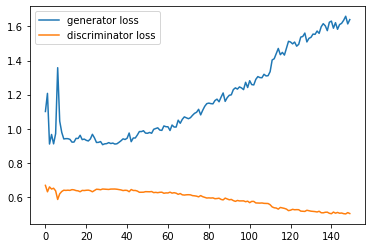

In [ ]:
plt.figure()
plt.plot(arr, label='generator loss')
plt.plot(arr2, label='discriminator loss')
plt.legend()
# plt.savefig('/content/first_hundred.png')
plt.show()

In [24]:
from google.colab.patches import cv2_imshow

img = train_dataset.get_item(0)[0]
cv2_imshow(img)

AttributeError: ignored

In [ ]:
arr2 = []
for i in d_loss_list:
    arr2.append(i/train_dataset.len())

Testing Stuff

In [ ]:
def fscs(image, k=256):
    dst = np.zeros(shape=image.shape)
    image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
    min = image.min()
    max = image.max()
    p = (k - 1) / (max - min)
    l = (min * -1) * p
    image = image * p + l
    image = np.asarray(image, dtype=int)
    return image

10 - minimal blur
20 - very blurred
80 - pretty high

In [ ]:
generator.eval()
discriminator.eval()

sharp, blur = test_dataset.get_item(0)

sharp = sharp.to(device)
sharp = torch.unsqueeze(sharp, dim=0)

# blur = medfilt2d(blur)

blur = blur.to(device)
blur = torch.unsqueeze(blur, dim=0)

output = generator.forward(blur)
d1_output = discriminator.forward(sharp)
d2_output = discriminator.forward(output)
print(d1_output)
print(d2_output)

tensor([[0.1278]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.1206]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
plt.figure()
blur_image = blur.cpu().detach().numpy()[0]
blur_image = np.transpose(blur_image, (1, 2, 0))
plt.imshow(blur_image)

plt.figure()
gen_image = output.cpu().detach().numpy()[0]
gen_image = np.transpose(gen_image, (1, 2, 0))
# image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
plt.imshow((gen_image))

plt.figure()
sharp_image = sharp.cpu().detach().numpy()[0]
sharp_image = np.transpose(sharp_image, (1, 2, 0))
plt.imshow(sharp_image)

plt.figure()
# image = blur.cpu().detach().numpy()[0] - output.cpu().detach().numpy()[0]
# image = np.transpose(image, (1, 2, 0))
plt.imshow(fscs(blur_image - gen_image))

plt.figure()
# image = sharp.cpu().detach().numpy()[0] - output.cpu().detach().numpy()[0]
# image = np.transpose(image, (1, 2, 0))
plt.imshow(fscs(sharp_image - gen_image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
train_dataset.len()

3758

In [ ]:
test_dataset.len()

980

In [ ]:
epoch_num = 150
state = torch.load(f'/content/drive/MyDrive/EE371Q/Reflect/reflect_train_epoch_{epoch_num}.pt')

discriminator.load_state_dict(state['discriminator'])
generator.load_state_dict(state['generator'])

d_optimizer.load_state_dict(state['d_optimizer'])
g_optimizer.load_state_dict(state['g_optimizer'])

In [ ]:
real_correct_list = []
fake_correct_list = []
real_fake_correct_list = []

In [ ]:
# print(test_dataset.len())
generator.eval()
discriminator.eval()

real_correct = 0
fake_correct = 0
real_fake_correct = 0

for i in range(0, test_dataset.len()):
    sharp, blur = test_dataset.get_item(i)

    sharp = sharp.to(device)
    sharp = torch.unsqueeze(sharp, dim=0)

    blur = blur.to(device)
    blur = torch.unsqueeze(blur, dim=0)

    output = generator.forward(blur)
    d1_output = discriminator.forward(sharp)
    d2_output = discriminator.forward(output)

    if d1_output > d2_output:
        real_fake_correct += 1
    
    if d2_output < 0.5:
        fake_correct += 1
    
    if d1_output > 0.5:
        real_correct += 1

    if (i + 1) % 100 == 0:
        print(f'fake correct: {fake_correct}, percent: {fake_correct / (i + 1)}')
        print(f'real correct: {real_correct}, percent: {real_correct / (i + 1)}')
        print(f'real_fake correct: {real_fake_correct}, percent: {real_fake_correct / (i + 1)}')

real_correct_list.append(real_correct / test_dataset.len())
fake_correct_list.append(fake_correct / test_dataset.len())
real_fake_correct_list.append(real_fake_correct / test_dataset.len())

fake correct: 94, percent: 0.94
real correct: 10, percent: 0.1
real_fake correct: 79, percent: 0.79
fake correct: 176, percent: 0.88
real correct: 33, percent: 0.165
real_fake correct: 149, percent: 0.745
fake correct: 260, percent: 0.8666666666666667
real correct: 63, percent: 0.21
real_fake correct: 220, percent: 0.7333333333333333
fake correct: 323, percent: 0.8075
real correct: 106, percent: 0.265
real_fake correct: 279, percent: 0.6975
fake correct: 415, percent: 0.83
real correct: 124, percent: 0.248
real_fake correct: 350, percent: 0.7
fake correct: 480, percent: 0.8
real correct: 169, percent: 0.2816666666666667
real_fake correct: 417, percent: 0.695
fake correct: 553, percent: 0.79
real correct: 206, percent: 0.29428571428571426
real_fake correct: 490, percent: 0.7
fake correct: 613, percent: 0.76625
real correct: 251, percent: 0.31375
real_fake correct: 554, percent: 0.6925
fake correct: 672, percent: 0.7466666666666667
real correct: 299, percent: 0.3322222222222222
real_fake

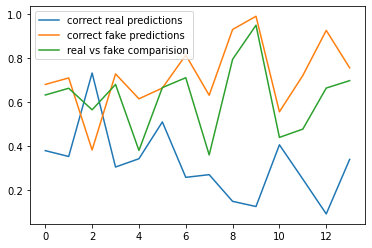

In [ ]:
plt.figure()
plt.plot(real_correct_list, label='correct real predictions')
plt.plot(fake_correct_list, label='correct fake predictions')
plt.plot(real_fake_correct_list, label='real vs fake comparision')
plt.legend()
# plt.savefig('/content/first_hundred.png')
plt.show()

In [ ]:
len(real_correct_list)

14

In [ ]:
print(real_correct_list, fake_correct_list, real_fake_correct_list)

[0.3806122448979592, 0.35408163265306125, 0.7336734693877551, 0.30612244897959184, 0.3438775510204082, 0.5112244897959184, 0.25918367346938775, 0.2714285714285714, 0.15, 0.12653061224489795, 0.40714285714285714, 0.2510204081632653, 0.09285714285714286, 0.3408163265306122] [0.6816326530612244, 0.7112244897959183, 0.3836734693877551, 0.7295918367346939, 0.6163265306122448, 0.6653061224489796, 0.8153061224489796, 0.6326530612244898, 0.9316326530612244, 0.9918367346938776, 0.5571428571428572, 0.7224489795918367, 0.9275510204081633, 0.7571428571428571] [0.6336734693877552, 0.6642857142857143, 0.5663265306122449, 0.6816326530612244, 0.3816326530612245, 0.6673469387755102, 0.7122448979591837, 0.36122448979591837, 0.7959183673469388, 0.9510204081632653, 0.44081632653061226, 0.4785714285714286, 0.6653061224489796, 0.6989795918367347]


In [ ]:
real_fake_correct_list.remove(651)

In [ ]:
batch_size = 1
total_batches = int(train_dataset.len() / batch_size)
# this will be the training loop, added batches
d_loss_list, g_loss_list = [], []

batch = train_dataset.get_batch(0, batch_size)

discriminator.train()
generator.train()

sharp, blur = batch[0]

d_optimizer.zero_grad()
sharp = sharp.to(device)
sharp = torch.unsqueeze(sharp, dim=0)


blur = blur.to(device)

blur_label = torch.zeros(1).to(device)
blur_label = blur_label.unsqueeze(1)


sharp_label = torch.ones(1).to(device)
sharp_label = sharp_label.unsqueeze(1)


# d_fake_output = discriminator.forward(blur)

d_real_output = discriminator.forward(sharp)
print(d_real_output)

d_real_loss = adversial_loss(d_real_output, sharp_label)
d_real_loss.backward()
print(d_real_loss)

tensor([[0.4688]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7575, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


In [ ]:
blur = blur.unsqueeze(0)  # if torch tensor
generated_output = generator.forward(blur)

In [ ]:
d_fake_output = discriminator.forward(generated_output)
print(d_fake_output)
d_fake_loss = adversial_loss(d_fake_output, blur_label)
d_fake_loss.backward()
print(d_fake_loss)

tensor([[0.]], device='cuda:0')
